# Bank Marketing Campaign Analysis

### Introduction

In this project, we analyze data from a Portuguese banking institution's marketing campaigns. The primary objective is to develop a predictive model that accurately identifies potential clients who are likely to subscribe to a term deposit. By predicting client responses before making a call, the bank can optimize its marketing strategy, focusing efforts on the most promising leads. This will improve the efficiency of marketing campaigns, reduce costs, and increase the success rate of term deposit subscriptions.

## Dataset Overview

The dataset comes from the UCI Machine Learning Repository and includes data from 17 marketing campaigns conducted between 2008 and 2013. It contains various attributes related to client demographics, past marketing interactions, and economic indicators.

Input Variables:

1. Age: Age of the client (numeric)
2. Job: Type of job (categorical)
3. Marital: Marital status (categorical)
4. Education: Education level (categorical)
5. Default: Has credit in default? (categorical)
6. Housing: Has housing loan? (categorical)
7. Loan: Has personal loan? (categorical)
8. Contact: Contact communication type (categorical)
9. Month: Last contact month of the year (categorical)
10. Day_of_week: Last contact day of the week (categorical)
11. Duration: Last contact duration, in seconds (numeric)
12. Campaign: Number of contacts performed during this campaign (numeric)
13. Pdays: Days since the client was last contacted from a previous campaign (numeric)
14. Previous: Number of contacts performed before this campaign (numeric)
15. Poutcome: Outcome of the previous marketing campaign (categorical)
16. Emp.var.rate: Employment variation rate (numeric)
17. Cons.price.idx: Consumer price index (numeric)
18. Cons.conf.idx: Consumer confidence index (numeric)
19. Euribor3m: Euribor 3 month rate (numeric)
20. Nr.employed: Number of employees (numeric)

Target Variable:

Y: Has the client subscribed to a term deposit? (binary: 'yes', 'no')


## Data Preparation

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
# Exclude 'duration' feature
df = df.drop('duration', axis=1)

# Replace 'unknown' with NaN and drop missing values
df.replace('unknown', np.nan, inplace=True)
df.dropna(inplace=True)


In [4]:
# Encode 'education' as an ordinal feature
education_order = {
    'illiterate': 0,
    'basic.4y': 1,
    'basic.6y': 2,
    'basic.9y': 3,
    'high.school': 4,
    'professional.course': 5,
    'university.degree': 6
}
df['education'] = df['education'].map(education_order)


In [5]:
# One-Hot Encode other categorical variables
categorical_vars = [
    'job', 'marital', 'default', 'housing', 'loan', 
    'contact', 'month', 'day_of_week', 'poutcome'
]
df = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

# Prepare the target variable
df['y'] = df['y'].map({'no': 0, 'yes': 1})

# Feature Scaling
from sklearn.preprocessing import StandardScaler

numerical_vars = [
    'age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
    'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'
]
scaler = StandardScaler()
df[numerical_vars] = scaler.fit_transform(df[numerical_vars])




In [6]:
# Define features and target variable
X = df.drop('y', axis=1)
y = df['y']


In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Use a smaller subset of the training data for hyperparameter tuning
X_train, _, y_train, _ = train_test_split(
    X_train_full, y_train_full, train_size=0.1, random_state=42, stratify=y_train_full
)



## Exploratory Data Analysis

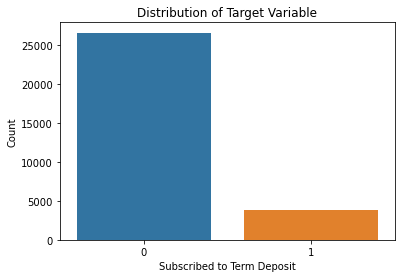

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of the target variable
sns.countplot(x='y', data=df)
plt.title('Distribution of Target Variable')
plt.xlabel('Subscribed to Term Deposit')
plt.ylabel('Count')
plt.show()


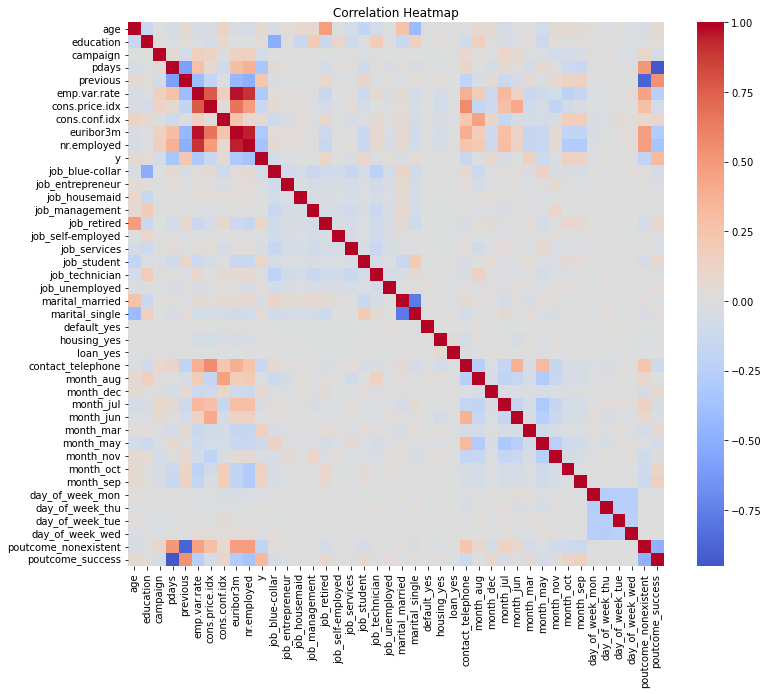

In [9]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()


## Baseline Model

In [10]:
# Calculate baseline accuracy
baseline_accuracy = y_train_full.value_counts(normalize=True).max()
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")


Baseline Accuracy: 0.8734


## Simple Logistic Regression Model

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from scipy.stats import uniform, randint
import time
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')


In [12]:


# Initialize the basic logistic regression model
basic_logreg = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model on the full training data
basic_logreg.fit(X_train_full, y_train_full)

# Calculate training accuracy
train_accuracy_basic = basic_logreg.score(X_train_full, y_train_full)
print(f"Training Accuracy of Basic Logistic Regression: {train_accuracy_basic:.4f}")

# Calculate testing accuracy
test_accuracy_basic = basic_logreg.score(X_test, y_test)
print(f"Testing Accuracy of Basic Logistic Regression: {test_accuracy_basic:.4f}")

# Predictions and probabilities
y_pred_basic = basic_logreg.predict(X_test)
y_pred_proba_basic = basic_logreg.predict_proba(X_test)[:, 1]

# Classification report
print("\nBasic Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_basic))

# ROC AUC Score
roc_auc_basic = roc_auc_score(y_test, y_pred_proba_basic)
print(f"Basic Logistic Regression ROC AUC Score: {roc_auc_basic:.4f}")



Training Accuracy of Basic Logistic Regression: 0.8895
Testing Accuracy of Basic Logistic Regression: 0.8862

Basic Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      5326
           1       0.62      0.26      0.37       772

    accuracy                           0.89      6098
   macro avg       0.76      0.62      0.65      6098
weighted avg       0.87      0.89      0.87      6098

Basic Logistic Regression ROC AUC Score: 0.7879


## Comparing Models

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import time

# Dictionary of models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

# List to store results
results = []

# Iterate over models
for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    results.append({
        'Model': model_name,
        'Train Time': f"{train_time:.4f}s",
        'Train Accuracy': f"{train_accuracy:.4f}",
        'Test Accuracy': f"{test_accuracy:.4f}"
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)


                 Model Train Time Train Accuracy Test Accuracy
0  Logistic Regression    0.0485s         0.8893        0.8791
1                  KNN    0.0015s         0.8967        0.8754
2        Decision Tree    0.0130s         0.9996        0.8150
3                  SVM    0.1525s         0.8913        0.8832


## Modeling and Hyperparameter Tuning

We will use four classifiers:

1. Logistic Regression
2. K-Nearest Neighbors (KNN)
3. Decision Tree
4. Support Vector Machine (SVM)

### Logistic Regression

In [14]:
# Define parameter distributions
param_dist_lr = {
    'penalty': ['l1', 'l2'],
    'C': uniform(0.1, 10),
    'solver': ['liblinear'],
    'class_weight': ['balanced']
}


In [15]:
# Initialize RandomizedSearchCV
random_search_lr = RandomizedSearchCV(
    LogisticRegression(max_iter=500, random_state=42),
    param_distributions=param_dist_lr,
    n_iter=5,
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=-1
)

# Fit the model
start_time = time.time()
random_search_lr.fit(X_train, y_train)
end_time = time.time()
print(f"Logistic Regression RandomizedSearchCV took {end_time - start_time:.2f} seconds")


Logistic Regression RandomizedSearchCV took 13.81 seconds


In [16]:
# Best estimator
best_lr = random_search_lr.best_estimator_

# Retrain on full training data
best_lr.fit(X_train_full, y_train_full)

# Predictions and probabilities
y_pred_lr = best_lr.predict(X_test)
y_pred_proba_lr = best_lr.predict_proba(X_test)[:, 1]

# Best parameters
print("Logistic Regression Best Parameters:", random_search_lr.best_params_)

# Classification report
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# ROC AUC Score
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"Logistic Regression ROC AUC Score: {roc_auc_lr:.4f}")


Logistic Regression Best Parameters: {'C': 0.6808361216819946, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      5326
           1       0.36      0.65      0.46       772

    accuracy                           0.81      6098
   macro avg       0.65      0.74      0.67      6098
weighted avg       0.87      0.81      0.83      6098

Logistic Regression ROC AUC Score: 0.7890


### K-Nearest Neighbors

In [17]:
# Define parameter distributions
param_dist_knn = {
    'n_neighbors': randint(3, 10),
    'weights': ['uniform'],
    'metric': ['euclidean']
}


In [18]:
# Initialize RandomizedSearchCV
random_search_knn = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=param_dist_knn,
    n_iter=5,
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=-1
)

# Fit the model
start_time = time.time()
random_search_knn.fit(X_train, y_train)
end_time = time.time()
print(f"KNN RandomizedSearchCV took {end_time - start_time:.2f} seconds")


KNN RandomizedSearchCV took 2.90 seconds


In [19]:
# Best estimator
best_knn = random_search_knn.best_estimator_

# Retrain on full training data
best_knn.fit(X_train_full, y_train_full)

# Predictions and probabilities
y_pred_knn = best_knn.predict(X_test)
y_pred_proba_knn = best_knn.predict_proba(X_test)[:, 1]

# Best parameters
print("KNN Best Parameters:", random_search_knn.best_params_)

# Classification report
print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

# ROC AUC Score
roc_auc_knn = roc_auc_score(y_test, y_pred_proba_knn)
print(f"KNN ROC AUC Score: {roc_auc_knn:.4f}")


KNN Best Parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      5326
           1       0.54      0.29      0.38       772

    accuracy                           0.88      6098
   macro avg       0.72      0.63      0.65      6098
weighted avg       0.86      0.88      0.86      6098

KNN ROC AUC Score: 0.7476


### Decision Tree

In [20]:
# Define parameter distributions
param_dist_dt = {
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 6),
    'min_samples_leaf': randint(1, 4),
    'class_weight': ['balanced'],
    'criterion': ['gini']
}


In [21]:
# Initialize RandomizedSearchCV
random_search_dt = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist_dt,
    n_iter=5,
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=-1
)

# Fit the model
start_time = time.time()
random_search_dt.fit(X_train, y_train)
end_time = time.time()
print(f"Decision Tree RandomizedSearchCV took {end_time - start_time:.2f} seconds")


Decision Tree RandomizedSearchCV took 0.22 seconds


In [22]:
# Best estimator
best_dt = random_search_dt.best_estimator_

# Retrain on full training data
best_dt.fit(X_train_full, y_train_full)

# Predictions and probabilities
y_pred_dt = best_dt.predict(X_test)
y_pred_proba_dt = best_dt.predict_proba(X_test)[:, 1]

# Best parameters
print("Decision Tree Best Parameters:", random_search_dt.best_params_)

# Classification report
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

# ROC AUC Score
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
print(f"Decision Tree ROC AUC Score: {roc_auc_dt:.4f}")


Decision Tree Best Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      5326
           1       0.36      0.64      0.46       772

    accuracy                           0.81      6098
   macro avg       0.65      0.74      0.67      6098
weighted avg       0.87      0.81      0.83      6098

Decision Tree ROC AUC Score: 0.7777


### Support Vector Machine

In [23]:
# Define parameter distributions
param_dist_svm = {
    'C': uniform(0.1, 10),
    'class_weight': ['balanced']
}


In [24]:
# Initialize RandomizedSearchCV
random_search_svm = RandomizedSearchCV(
    LinearSVC(max_iter=1000, random_state=42),
    param_distributions=param_dist_svm,
    n_iter=3,
    scoring='f1',
    cv=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model
start_time = time.time()
random_search_svm.fit(X_train, y_train)
end_time = time.time()
print(f"LinearSVC RandomizedSearchCV took {end_time - start_time:.2f} seconds")


LinearSVC RandomizedSearchCV took 0.23 seconds


In [25]:
# Best estimator
best_svm = random_search_svm.best_estimator_

# Retrain on full training data
best_svm.fit(X_train_full, y_train_full)

# Predictions and decision function scores
y_pred_svm = best_svm.predict(X_test)
y_scores_svm = best_svm.decision_function(X_test)

# Best parameters
print("LinearSVC Best Parameters:", random_search_svm.best_params_)

# Classification report
print("\nLinearSVC Classification Report:")
print(classification_report(y_test, y_pred_svm))

# ROC AUC Score
roc_auc_svm = roc_auc_score(y_test, y_scores_svm)
print(f"LinearSVC ROC AUC Score: {roc_auc_svm:.4f}")


LinearSVC Best Parameters: {'C': 9.60714306409916, 'class_weight': 'balanced'}

LinearSVC Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      5326
           1       0.47      0.45      0.46       772

    accuracy                           0.87      6098
   macro avg       0.70      0.69      0.69      6098
weighted avg       0.86      0.87      0.86      6098

LinearSVC ROC AUC Score: 0.7819


### Baseline Logistic Regression

In [26]:
# Baseline Logistic Regression
baseline_lr = LogisticRegression(max_iter=500, random_state=42)
baseline_lr.fit(X_train_full, y_train_full)

# Predictions and probabilities
y_pred_baseline = baseline_lr.predict(X_test)
y_pred_proba_baseline = baseline_lr.predict_proba(X_test)[:, 1]

# Classification report
print("\nBaseline Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_baseline))

# ROC AUC Score
roc_auc_baseline = roc_auc_score(y_test, y_pred_proba_baseline)
print(f"Baseline Logistic Regression ROC AUC Score: {roc_auc_baseline:.4f}")



Baseline Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      5326
           1       0.62      0.26      0.37       772

    accuracy                           0.89      6098
   macro avg       0.76      0.62      0.65      6098
weighted avg       0.87      0.89      0.87      6098

Baseline Logistic Regression ROC AUC Score: 0.7879


### Summarizing Results

In [27]:
# Function to collect metrics
def get_metrics(y_true, y_pred, y_scores, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_true, y_scores)
    metrics = {
        'Model': model_name,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score'],
        'ROC AUC': roc_auc
    }
    return metrics

# Collect results
results = []

results.append(get_metrics(y_test, y_pred_basic, y_pred_proba_basic, 'Basic Logistic Regression'))
results.append(get_metrics(y_test, y_pred_baseline, y_pred_proba_baseline, 'Baseline Logistic Regression'))
results.append(get_metrics(y_test, y_pred_lr, y_pred_proba_lr, 'Tuned Logistic Regression'))
results.append(get_metrics(y_test, y_pred_knn, y_pred_proba_knn, 'Tuned KNN'))
results.append(get_metrics(y_test, y_pred_dt, y_pred_proba_dt, 'Tuned Decision Tree'))
results.append(get_metrics(y_test, y_pred_svm, y_scores_svm, 'Tuned LinearSVC'))

# Create DataFrame
results_df = pd.DataFrame(results)

print("\nModel Comparison:")
print(results_df)




Model Comparison:
                          Model  Precision    Recall  F1-Score   ROC AUC
0     Basic Logistic Regression   0.619632  0.261658  0.367942  0.787928
1  Baseline Logistic Regression   0.619632  0.261658  0.367942  0.787928
2     Tuned Logistic Regression   0.360231  0.647668  0.462963  0.789001
3                     Tuned KNN   0.536058  0.288860  0.375421  0.747634
4           Tuned Decision Tree   0.358339  0.637306  0.458741  0.777664
5               Tuned LinearSVC   0.469251  0.454663  0.461842  0.781882


In [28]:
# Since Tuned Log Reg is our best model, we will use it to calculate the accuracy
# Calculate training accuracy
train_accuracy = best_lr.score(X_train_full, y_train_full)
print(f"Training Accuracy of Tuned Logistic Regression: {train_accuracy:.4f}")

# Calculate testing accuracy
test_accuracy = best_lr.score(X_test, y_test)
print(f"Testing Accuracy of Tuned Logistic Regression: {test_accuracy:.4f}")

Training Accuracy of Tuned Logistic Regression: 0.8177
Testing Accuracy of Tuned Logistic Regression: 0.8098


## Visualizations

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt


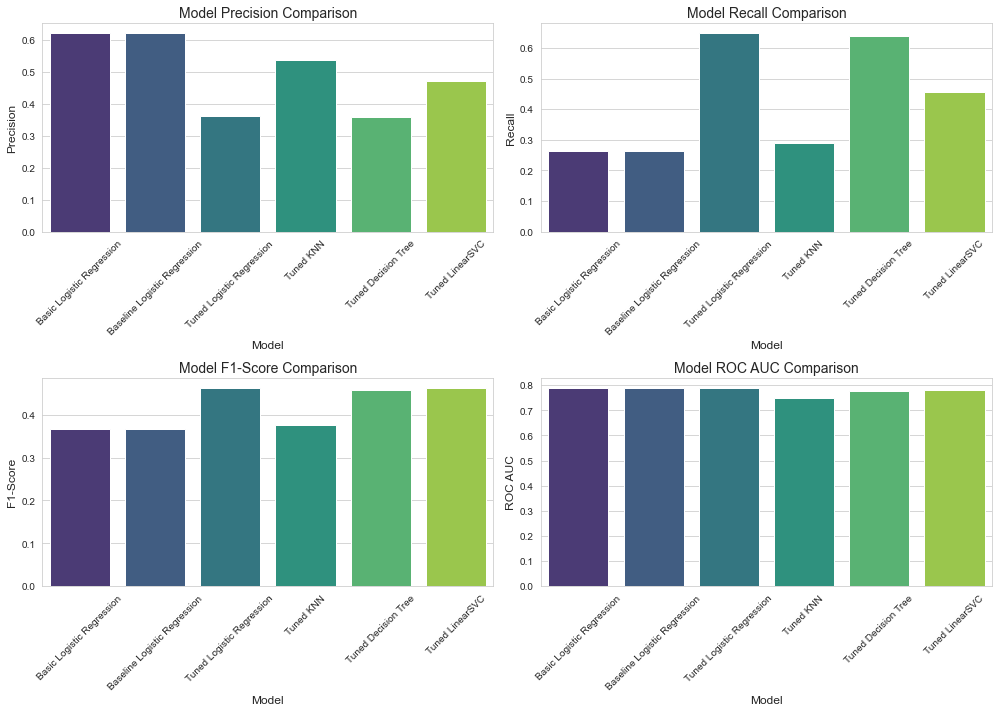

In [30]:
# Set the style
sns.set_style('whitegrid')

# Create subplots for each metric
metrics = ['Precision', 'Recall', 'F1-Score', 'ROC AUC']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    sns.barplot(x='Model', y=metric, data=results_df, ax=axes[idx], palette='viridis')
    axes[idx].set_title(f'Model {metric} Comparison', fontsize=14)
    axes[idx].set_xlabel('Model', fontsize=12)
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()


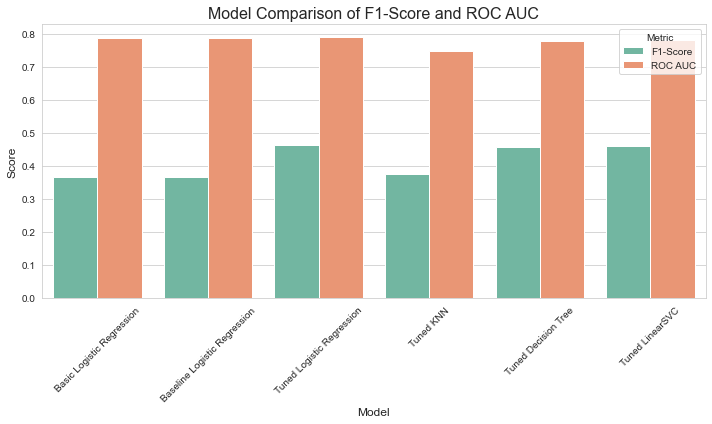

In [31]:
# Melt the DataFrame to long format for plotting
metrics_to_plot = ['F1-Score', 'ROC AUC']
results_melted = pd.melt(results_df, id_vars='Model', value_vars=metrics_to_plot,
                         var_name='Metric', value_name='Score')

# Create a grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted, palette='Set2')
plt.title('Model Comparison of F1-Score and ROC AUC', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


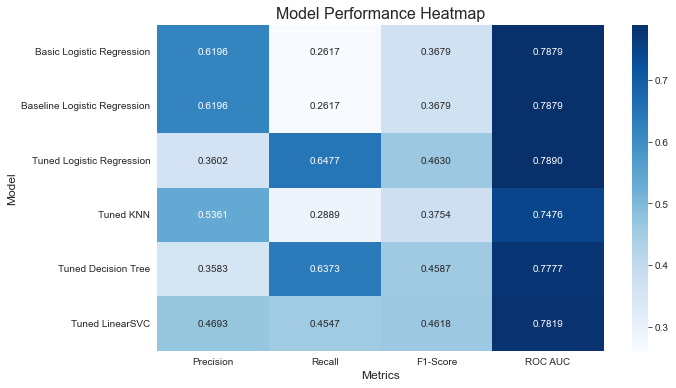

In [32]:
# Set 'Model' as index for the heatmap
heatmap_data = results_df.set_index('Model')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt=".4f")
plt.title('Model Performance Heatmap', fontsize=16)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.show()


## Findings and Conclusions

Our analysis compared six models to predict client subscription to term deposits. The Tuned Logistic Regression model stood out, significantly improving recall to 64.77% from 26.17% in the basic logistic regression, indicating a better ability to identify actual subscribers. Although its precision decreased to 36.02%, the higher recall led to an improved F1-Score of 46.30% and a marginally better ROC AUC of 0.7890.

This trade-off between precision and recall is acceptable in the marketing context, where reaching more potential subscribers can increase overall campaign success despite some false positives. Therefore, we recommend implementing the Tuned Logistic Regression model to enhance the bank's marketing strategy by focusing efforts on clients more likely to subscribe, optimizing resource allocation, and potentially increasing term deposit subscriptions.